In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
!git clone https://github.com/CipiOrhei/TMBuD

In [ ]:
%pip install poutyne
%pip install segmentation-models-pytorch

1)
Можно применять различные модели, можно даже что то вроде случайного леса, но в этой задаче я считаю целесообразным применять глубокое обучение, в задаче сегментации это так вообще единственный вариант, по идее можно тестировать различные архитектуры, можно пользоваться предобученными моделями, а можно создавать с нуля, ну я буду использовать предобученную реснет и попробую несколько разных функций потерь

In [4]:
import torch
torch.cuda.is_available()

True

2) для решения этой задачи я планирую обучить 2 модели сегментации, одна будет сегментировать окна, вторая фасад здания, маски, которые я получу с окон я попробую анализировать и считать, здесь у меня есть несколько идей: 1 это подавать маски на вход каком нибдуь модели решающей задачу регрессии, тогда на выходе должно быть одно число, собственно, ответ на задачу, а вторая идея это воспользоваться cv2.findcountours, в свое время она себя хорошо показала для меня и мне кажется, что проблем с поиском контуров на бинарной картинке, где есть только окна и не-окна не возникнет

3) датасет я собрал выше, там команда git clone, смотрел несколько вариантов, этот почему то понравился, по идее есть предустановленный метод, позволяющий извлечь этот датасет из изображений и привести к виду np.array, но у меня возникли проблемы с зависимостями и я поленился разбираться, а просто собрал все ручками

In [5]:
import pandas
import os
import torch
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
from IPython.display import clear_output
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

In [6]:
root = 'TMBuD/'
images_dir = root + 'images/'
lesions_dir = root + 'gt_label/'
dataset_csv = root + 'DATASET SPLIT.csv'

Ну я сразу скажу, что здесь вроде как предусмотрен какой то файл для более простой загрузки датасета, наверное, я сильно не разбирался, установил зависимости, он выдал мне какую то непонятную ошибку и я решил, что мне проще просто использовать эти картинки и не мучить голову свою

In [7]:
table = pandas.read_csv(dataset_csv)

In [8]:
table.head()

,Picture Name,Building Name,Coordinates Landmark,Coordinates image,GT salient edges,GT labels,Condition,Quality,Dataset STANDARD,Dataset 3_2,Dataset 3_5_NIGHT,Dataset 3_N,SEMSEG_EVAL_FULL,END
0,1,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75174775294593; 21.22478407583839,Done,Done,NIGHT,GOOD,TRAIN,None,TEST,TEST,TRAIN,'
1,2,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751577081296176; 21.22472497882864,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TRAIN,'
2,3,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TEST,'
3,4,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,VAL,TEST,TEST,TEST,TRAIN,'
4,5,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751259791003264; 21.224710204576198,Done,Done,DAY,GOOD,TEST,None,None,None,TRAIN,'


Так, ну для начала я понял, что смысла в этой таблице для меня особо нет т.к. здесь куча данных, но то, что мне нужно (например количество окон) отсутствует, как и адрес изображения, не знаю какой смысл мне в этой цифре, мол, вот 1 изображение. Была бы польза от полного имени

In [9]:
def get_name(numb):
    if len(str(numb)) == 1:
        return f'0000{numb}.png'
    if len(str(numb)) == 2:
        return f'000{numb}.png'
    if len(str(numb)) == 3:
        return f'00{numb}.png'
    if len(str(numb)) == 4:
        return f'0{numb}.png'
    if len(str(numb)) == 5:
        return f'{numb}.png'

In [2]:
images = []
lesions = []
size = (256, 256)

for i in range(1, 11000):
  img_or = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  img_les = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  if img_or is not None and img_les is not None:
    images.append(img_or)
    lesions.append(img_les)

NameError: ignored

In [ ]:
%pip install tqdm

In [12]:
from tqdm import tqdm

4) Ну, собственно, вот здесь я и провожу нужную мне разметку, пока что только для окон

Следующий цикл проходит по сегментированным изображениям и всего лишь удаляет все, кроме окон, ну и я решил раз уж классов всего 2 (окна и не окна), из 3 слоев сделать один

100%|██████████| 298/298 [16:00<00:00,  3.22s/it]


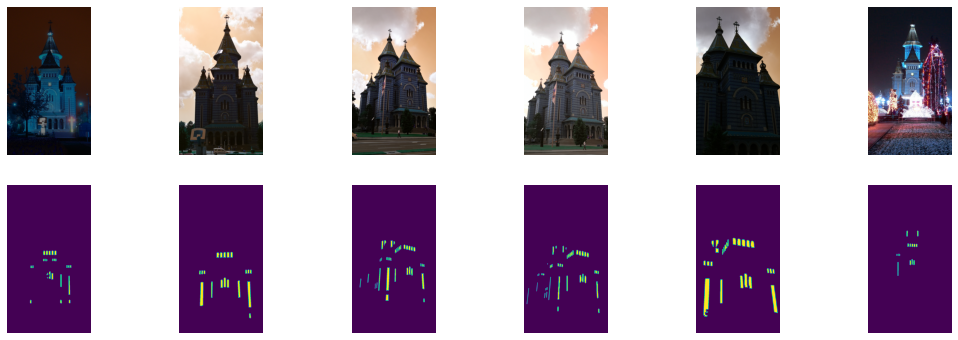

In [13]:
df_windows = []
for image in tqdm(lesions):
  les = np.zeros(image.shape[:2])
  for idx_row, row in enumerate(image):
    for idx_col, cell in enumerate(row):
      if any(cell != [0, 255, 255]):
        les[idx_row, idx_col] = 0
      else:
        les[idx_row, idx_col] = 1
  df_windows.append(les)

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

In [14]:
def showing_result(image, result):
  plt.figure(figsize=(18, 6))
  for i in range(6):
      plt.subplot(2, 6, i+1)
      plt.axis("off")
      plt.imshow(image[i].numpy().transpose(1, 2, 0))

      plt.subplot(2, 6, i+7)
      plt.axis("off")
      plt.imshow(result[i].squeeze())
  plt.show();

Эти все махинации нужны чтобы эти данные можно было подать на обучение, тут изменение размера, разбивка на батчи и т.д.

In [15]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in df_windows]

In [16]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [200, 275])

In [17]:
X, Y = np.array(X, dtype=np.float32), np.array(Y, np.float32)

In [19]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Начнем собирать и тренировать модель

Здесь просто происходит обработка данных в соответствии с обучаемой моделью

In [23]:
# test_x = test_x.float()
seg_model = smp.Unet(
    encoder_name='resnet34', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)
imgs = seg_model(test_x)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Уже удалил ячейку кода, чтобы не засорять, но вывод решил оставить, вот, что размечала модель без обучения, по моему симпатично)

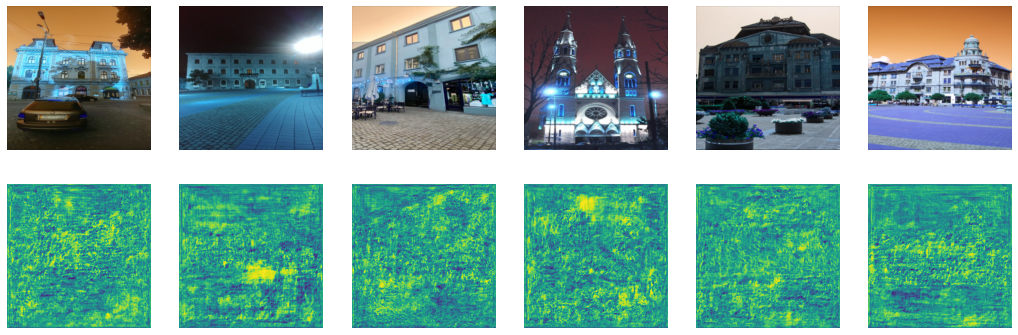

In [27]:
showing_result(test_x, imgs)

Обучение модели

In [ ]:
%pip install pytorch-lightning==1.5.4

In [31]:
def bce_loss(y_real, y_pred):
  y_pred = torch.sigmoid(y_pred)
  res = y_real * torch.log(y_pred) + (1 - y_real)*torch.log(1 - y_pred)
  return -res.mean()

In [32]:
from time import time

In [33]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device, dtype=torch.float)
            Y_batch = Y_batch.to(device, dtype=torch.float)
            # print('batch')
            opt.zero_grad()
            # data to device

            # set parameter gradients to zero

            # forward
            Y_pred = model.forward(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model.forward(X_val.to(device)).detach().cpu()# detach and put into cpu

        plt.figure(figsize=(18, 6))
        clear_output(wait=True)
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(X_val[i].numpy().transpose(1, 2, 0))

            plt.subplot(2, 6, i+7)
            plt.axis("off")
            plt.imshow(Y_hat[i].squeeze())
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show();

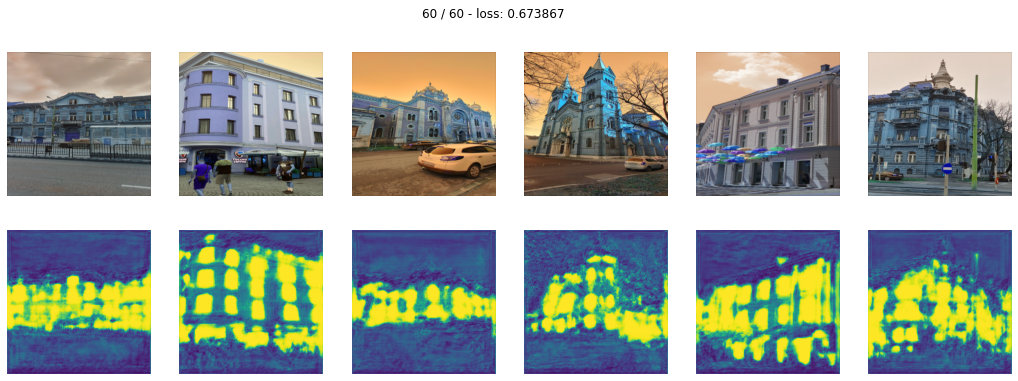

In [34]:
max_epochs = 60
optim = torch.optim.Adam(seg_model.parameters(), lr=0.0001)
seg_model.to(device)
train(seg_model, optim, bce_loss, max_epochs, data_tr, data_val)

Ну вот сверху что то похожее, конечно, можно ввести порог уверенности, но я решил попробовать новую функцию потерь

Код снизу нужен для сохранения результатов обучение, на практике я его пока не использовал, не подгружал, в коллбе на gpu как то необычайно быстро учится эта модель, все таки наверное не целиком, хотя я и не замораживал слои никакие специально, ну видимо это уже происходит под капотом когда я указыаю, что она predreined=True, не уверен, будь больше времени и если бы это было нужно я бы еще попробовал разобраться, но так просто перелопатил кучу примеров, документацию глянул и нигде их специально не замораживали

In [36]:
# from google.colab import files

In [35]:
# torch.save(seg_model.state_dict(), 'seg_model.pt')
# files.download('seg_model.pt')

А вот, собственно, почему я решил новую функцию потерь, порог уверенности, конечно, делает результаты лучше, но все еще не то, что нужно

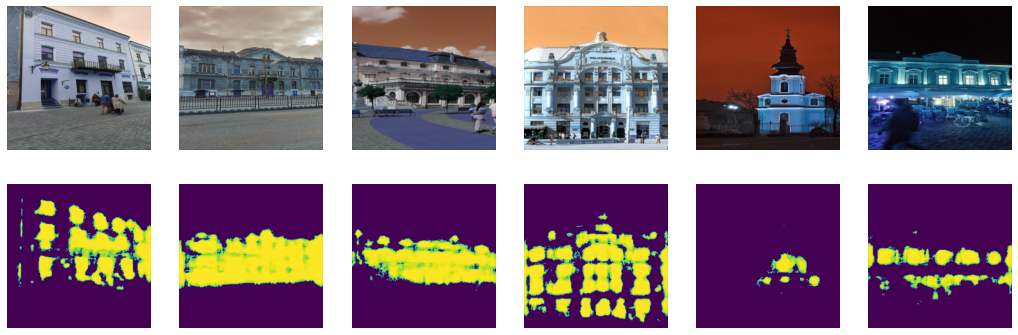

In [37]:
with torch.no_grad():
  x = next(iter(data_ts))[0]
  x = x.to(device)
  res = seg_model(x)
  res[res<0.7] = 0
  res = res.cpu().detach().numpy()
  x = x.cpu()
showing_result(x, res)

In [40]:
def dice_loss(y_real, y_pred):
    y_real, y_pred = y_real.view(-1), y_pred.view(-1)
    num = torch.sum(2*y_real*y_pred)
    den = y_real.sum() + y_pred.sum()
    res = 1 - (num + 1*10**-8) / (den + 1*10**-8)
    return res

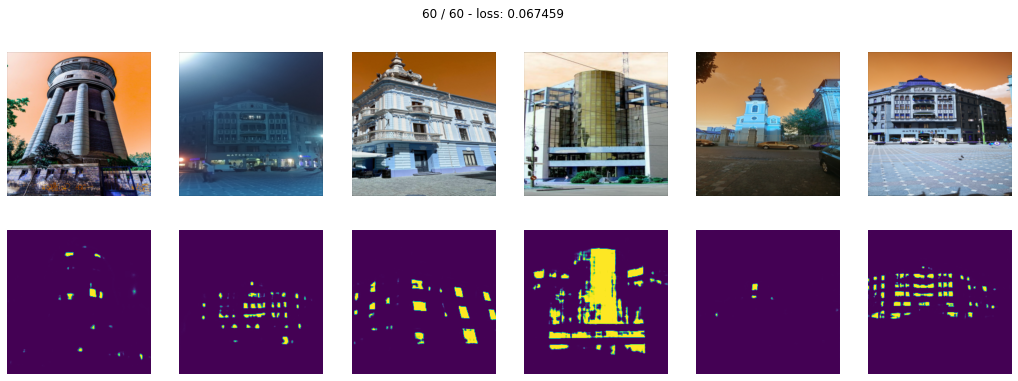

In [49]:
max_epochs = 60
optim = torch.optim.Adam(seg_model.parameters(), lr=0.0001)
seg_model.to(device)
train(seg_model, optim, dice_loss, max_epochs, data_tr, data_val)

Честно говоря, я не ожидал, что изменение функции потерь так сильно улучшит результат, я доволен, мне жаль, что я не написал метрики, но кажется уже не успеваю, на решение это не повлияет, но еще пару дней и оформил бы красиво, а так еще слишком много нужно сделать(

Да, результат далеко не идеален, на этом примере окна например сливаются и их даже человек уже не смог бы посчитать, на других примерах, например, окна проезжающих мимо машин тоже отмечались, нужно по-хорошему еще долго сидеть над самой сегментацией, а не переходить дальше

In [42]:
def show_mask(image):
  '''image view (256, 256)'''
  plt.imshow(image.squeeze())


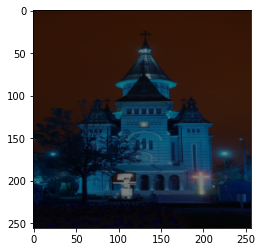

In [43]:
def segm_windows(x):
  '''
  x must be a numpy array view [256, 256, 3]
  '''
  x = x[np.newaxis]
  x = np.rollaxis(x, 3, 1)
  x = torch.tensor(x)
  x = x.to(device)
  result = seg_model(x)
  result = result.cpu().detach().numpy()
  return result[0][0]
photo = X[0]
result = segm_windows(photo)
plt.imshow(photo)

Я не разобрался, как можно сделать с линейной регрессией, в примере, на который я опирался на выходе вектор из 8 чисел и я как то так и не смог понять, каким образом он превращается в число и как мне ее обучать, максимум что я могу сделать это вручную разметить количество окон например, а потом подавать в лоссс как таргет, но тогда у меня должен быть Linear (x, 1), и у меня сильное подозрение, что это не сработает т.к. модель проосто не поймет в каком моменте она ошиблась, если с полносвязного пришла куча чисел и непонятно какое именно из них было слишком большое, к примеру

А ниже код, с которым я пытался найти границы при помощи opencv, ну почему то он всегда давал 4 метки для contours, так не должно быть, но я решил не задерживаться и идти дальше, либо к регрессии либо к сегментации фасада

In [45]:
# import numpy as np
# import cv2 as cv
# im = cv.imread('logo.png')
# # im = result
# # imgray = im
# assert im is not None, "file could not be read, check with os.path.exists()"
# imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
# print(imgray.shape, imgray.dtype, type(imgray))
# ret, thresh = cv.threshold(imgray, 127, 255, 0)
# contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

(260, 260, 3) <class 'numpy.ndarray'>
(260, 260) uint8 <class 'numpy.ndarray'>


In [46]:
def find_windows(img):
  """Спойлер, она почему то не сработала(("""
  img = to_bin(img)
  ret, thresh = cv.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  img_contours = np.uint8(np.zeros((my_photo.shape[0],my_photo.shape[1])))


In [ ]:
def to_bin(img):
  img = np.array(img)
  bond = 0.99
  img[img>bond]=1
  img[img<=bond]=0
  img = np.array(img, np.uint8)
  return img
show_mask(to_bin(result))

теперь надо циклом вот так вот обработать все изображения и вручную разметить количество окон((

По задумке я должен был видеть картинку, считать окна и вводить их, а после ввода видеть другую картинку и так почти 300 раз, но что то пошло не так на моменте, когда вывод поля для ввода стирал картинку, потом еще я понял, что проблемы с регрессией, ну и силы у меня немножко кончились, мне бы совет какой, хоть в правильном ли я направлении движусь, ну или ощущение, что торопится некуда, а то так я в условиях относительного дефицита времении все делаю

In [ ]:
# count_wind = []
# for i in df_windows:
#   # show_mask(i)
#   plt.imshow(i)
#   count = int(input())
#   count_wind.append(count)

Результат ручной разметки я планировал сохранить в таблицу, вероятно я бы связал ее с именами и изменил бы метод подгрузки, не вот это вот если изображение не None, и маска не None, то сохраняем, а берем имя сразу из таблицы, там же метки хранятся и все грузим отмечаем, если бы мне нужно было дальше работать с этим, подбирать функции, архитектуры и т.д. я бы так и сделал, сейчас не вижу большого смысла

In [ ]:
# >>> d = {
# ...     'Algothime': ['KNN', 'SVM', 'MLP'],
# ...     'Param. 1': ['-', '-', '-'],
# ...     'Param. 2': ['-', '-', '-'],
# ...     'Plage param. 1': ['-', '-', '-'],
# ...     'Plage param. 2': ['-', '-', '-']
# ... }
# >>> df = pd.DataFrame(data=d)
# >>> df
# это я разметку хотел создать по количеству окон и сохранить в csv, но теперь вижу, что это кажется бессмысленно, и решил не терять время

In [57]:
images.shape

torch.Size([25, 3, 256, 256])

сделаю сегментацию фасада здания, та же методика, что и для окон, но добавляем цвет фасада. (цвета взял из parse_database.py)

TypeError: ignored

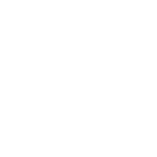

In [56]:
# df_building = []
# for image in tqdm(lesions):
#   les = np.zeros(image.shape[:2])
#   for idx_row, row in enumerate(image):
#     for idx_col, cell in enumerate(row):
#       if not any(cell != (0, 255, 255)) or not any(cell != (125, 125, 0)):
#         les[idx_row, idx_col] = 1        
#   df_building.append(les)

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

In [ ]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in df_building]
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [200, 275])
X, Y = np.array(X, dtype=np.float32), np.array(Y, np.float32)
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
seg_building = smp.Unet(
    encoder_name='resnet34', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)


In [ ]:
max_epochs = 60
optim = torch.optim.Adam(seg_model.parameters(), lr=0.0001)
seg_model.to(device)
train(seg_building, optim, bce_loss, max_epochs, data_tr, data_val)